### Build a Linear Regression Model to predict house sales prices

This dataset contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.

The dataset has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). Actual column names can be found here: https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt


In [39]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [40]:
df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
df.shape

(2930, 82)

In [41]:
def transform_features(df):
    return df

def select_features(df):
    sel_col = ['Gr Liv Area','SalePrice']
    return df[sel_col]

def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    numeric_train = train.select_dtypes(include = ['float','int'])
    numeric_test = test.select_dtypes(include = ['float','int'])
    
    #drop the target column from the feature columns
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    #instaniate the Linear Regression Model
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train[target])
    #train_prediction = lr.predict(train[features])
    test_prediction = lr.predict(test[features])
    
    rmse = mean_squared_error(test_prediction, test[target])**(1/2)
    
    return rmse


transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
        
rmse

57088.25161263909

#### The analysis process to generate the prediction model function above

#### Feature Transformation

1. Drop any columns that has more than 5% missing value or leak information about the sale
2. Transform feature columns into proper format:
    - Non-ordinal to categorical
    - Scaling numerical columns
    - Filling in missing values


Drop columns with more than 5% missing values 

In [42]:
missing_val = df.isnull().sum()
cols_drop = missing_val[missing_val > len(df)*0.05].index
df = df.drop(cols_drop, axis=1)

For text columns, since there isn't appropriate ways to fill in missing values, we will drop text columns with more than 1 missing value.

In [43]:
textnull_cols = df.select_dtypes(include = 'object').isnull().sum()
text_cols_drop = textnull_cols[textnull_cols >= 1].index
df = df.drop(text_cols_drop, axis=1)

For columns with less than 5% missing values, we fill in the most popular value of each column

In [44]:
nums_missing = df.select_dtypes(include = ['float','int']).isnull().sum()
cols_fillin = nums_missing[(nums_missing <= len(df)*0.05) & (nums_missing > 0)].sort_values()
cols_fillin

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [45]:
values_fillin = df[cols_fillin.index].mode().to_dict(orient='records')[0]
values_fillin

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [46]:
df = df.fillna(values_fillin)
df[cols_fillin.index].isnull().sum()

BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Garage Cars       0
Garage Area       0
Bsmt Full Bath    0
Bsmt Half Bath    0
Mas Vnr Area      0
dtype: int64

In [47]:
df.isnull().sum().value_counts()

0    64
dtype: int64

Transform the columns with info of Year of the sales, to better reflect the age of the house

In [48]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [49]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [50]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

Drop the columns that aren't useful for model prediction and leak sales information

In [51]:
df = df.drop(["PID", "Order"], axis=1)

df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

#### Feature Selection

Check correlations among numerical features, to get overview of features with strongest correlation with SalePrice

In [58]:
numeric_df = trans_df.select_dtypes(include = ['float','int'])
numeric_df

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,0,0,1338,1.0,0.0,2,0,2,1,6,0,2.0,582.0,0,0,170,0,0,0,0,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,0,0,1616,1.0,0.0,2,0,2,1,5,1,2.0,608.0,237,152,0,0,0,0,0,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,776,0,1804,0.0,0.0,2,1,3,1,7,1,2.0,442.0,140,60,0,0,0,0,0,189000,11,11


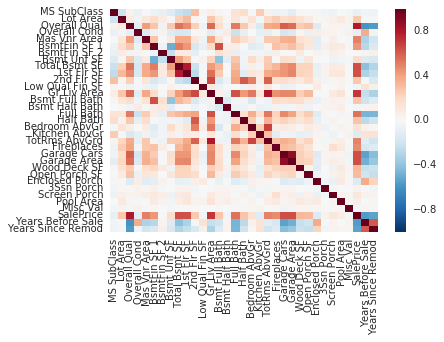

In [59]:
import seaborn as sns
sns.heatmap(numeric_df.corr())

In [60]:
numeric_corr = numeric_df.corr()['SalePrice'].abs().sort_values()
numeric_corr

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

Drop the columns with less than 0.4 correlation coeffcients. Could be experimenting later to optimize model 

In [61]:
low_corr_drop = numeric_corr[numeric_corr < 0.4].index
trans_df = trans_df.drop(low_corr_drop, axis = 1)

Create a list of column names from documentation that are *meant* to be categorical

In [62]:
nominal_features = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

Explore the unique values of categorical columns. If they have too many unique values then it will create too many columns when dummy code them. If they have too few unique values then the columns are low variance and don't provide value to the model prediction

In [63]:
#Check if categorical columns are in transformed dataframe
cat_cols_trans = []
for col in nominal_features:
    if col in trans_df.columns:
        cat_cols_trans.append(col)
cat_cols_trans        


['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

Check unique values of these categorical columns

In [64]:
catcols_unique_count = trans_df[cat_cols_trans].apply(lambda col: len(col.unique())).sort_values()
catcols_unique_count

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

We will cut off at 10 unique values and drop three columns with too many unique values

In [67]:
cols_drop = catcols_unique_count[catcols_unique_count < 10].index
trans_df = trans_df.drop(cols_drop, axis=1)

Tranform those columns to categorical and dummy code them

In [69]:
cat_cols = trans_df.select_dtypes(include=['object'])
for col in cat_cols:
    trans_df[col] = trans_df[col].astype('category')
    
dummy_cols = pd.get_dummies(trans_df.select_dtypes(include=['category']))
trans_df = pd.concat([trans_df, dummy_cols], axis = 1)

In [66]:
df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

def transform_features(df):
    #drop >5% missing values
    missing_val = df.isnull().sum()
    cols_drop = missing_val[missing_val > len(df)*0.05].index
    df = df.drop(cols_drop, axis=1)
    
    #drop text columns with more than 1 missing value
    textnull_cols = df.select_dtypes(include = 'object').isnull().sum()
    text_cols_drop = textnull_cols[textnull_cols >= 1].index
    df = df.drop(text_cols_drop, axis=1)
    
    #fill in values with mode of columns with less than 5% missing values
    nums_missing = df.select_dtypes(include = ['float','int']).isnull().sum()
    cols_fillin = nums_missing[(nums_missing <= len(df)*0.05) & (nums_missing > 0)].sort_values()
    values_fillin = df[cols_fillin.index].mode().to_dict(orient='records')[0]
    df = df.fillna(values_fillin)
    
    #transform Year columns
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #drop others unusable columns
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df


def select_features(trans_df):
    #Filter high correlated numerical columns
    numeric_df = trans_df.select_dtypes(include = ['float','int'])
    numeric_corr = numeric_df.corr()['SalePrice'].abs().sort_values()
    low_corr_drop = numeric_corr[numeric_corr < 0.4].index
    trans_df = trans_df.drop(low_corr_drop, axis = 1)
    
    nominal_features = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    cat_cols_trans = []
    for col in nominal_features:
        if col in trans_df.columns:
            cat_cols_trans.append(col)
    
    catcols_unique_count = trans_df[cat_cols_trans].apply(lambda col: len(col.unique())).sort_values()
    cols_drop = catcols_unique_count[catcols_unique_count < 10].index
    trans_df = trans_df.drop(cols_drop, axis=1)
            
    cat_cols = trans_df.select_dtypes(include=['object'])
    for col in cat_cols:
        trans_df[col] = trans_df[col].astype('category')

    dummy_cols = pd.get_dummies(trans_df.select_dtypes(include=['category']))
    trans_df = pd.concat([trans_df, dummy_cols], axis = 1)
    
    return trans_df


def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    numeric_train = train.select_dtypes(include = ['float','int'])
    numeric_test = test.select_dtypes(include = ['float','int'])
    
    #drop the target column from the feature columns
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    #instaniate the Linear Regression Model
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train[target])
    #train_prediction = lr.predict(train[features])
    test_prediction = lr.predict(test[features])
    
    rmse = mean_squared_error(test_prediction, test[target])**(1/2)
    
    return rmse


trans_df = transform_features(df)
filtered_df = select_features(trans_df)
rmse = train_and_test(filtered_df)
        
rmse

55275.36731241307